# Sleep EEG Data Augmentation

In this data augmentation approach, we will be implementing a basic data augmentation approach using noise addition in order to help enhance the performance of the classifier and adjust the ratio of each class of the sleep stage classes. 

$$ 
New\_EEG=Raw\_EEG+Noise
$$

we will start by adding the required libraries and noise addition functions:

In [1]:
import os
import mne
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from Chua import chua
from noise import SNR_Set
import matplotlib.pyplot as plt
%matplotlib inline

Then, we load the sleep EEG recording along with its hypnogram: 

In [2]:
raw=mne.io.read_raw_edf('sleep.edf')
hypno=mne.read_annotations('hypno.edf')
aa=raw.set_annotations(hypno, emit_warning=False)
print(raw.info)

Extracting EDF parameters from C:\Users\Client\Desktop\sleep_eeg_da\sleep.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
<Info | 7 non-empty values
 bads: []
 ch_names: EEG Fpz-Cz, EEG Pz-Oz, EOG horizontal, Resp oro-nasal, EMG ...
 chs: 7 EEG
 custom_ref_applied: False
 highpass: 0.5 Hz
 lowpass: 100.0 Hz
 meas_date: 1989-04-24 16:13:00 UTC
 nchan: 7
 projs: []
 sfreq: 100.0 Hz
>


Effective window size : 20.480 (s)


C:\Users\Client\AppData\Local\Temp/ipykernel_11040/854291086.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(fmax=50)


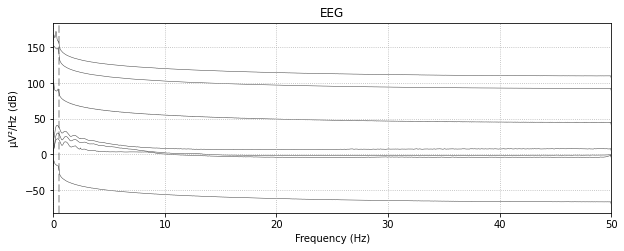

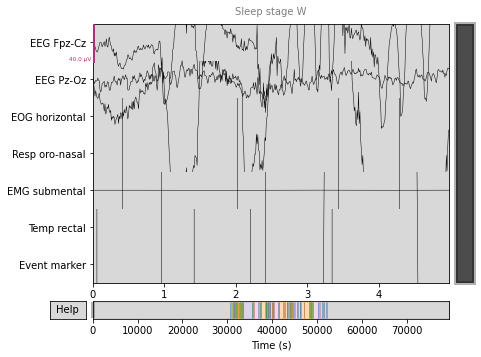

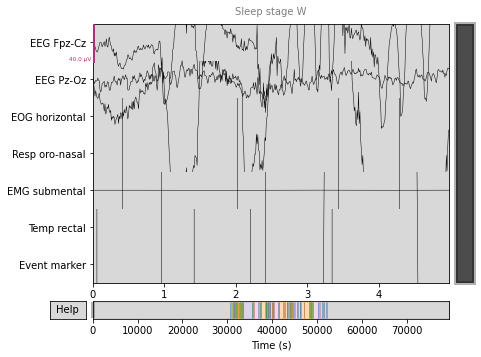

In [3]:
raw.plot_psd(fmax=50)
raw.plot(duration=5)

The following commands will show the times of occurance of each event:

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage ?', 'Sleep stage R', 'Sleep stage W']


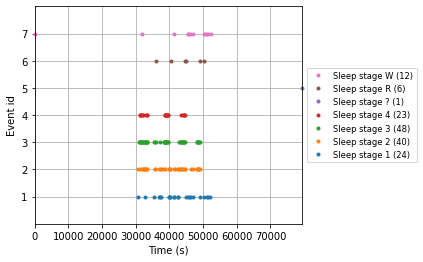

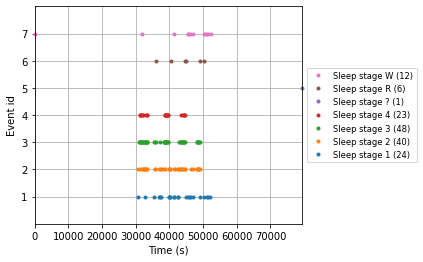

In [4]:
event_id = {'Sleep stage 1': 1,
                              'Sleep stage 2': 2,
                              'Sleep stage 3': 3,
                              'Sleep stage 4': 4,
                              'Sleep stage ?': 5,
                              'Sleep stage R': 6,
                              'Sleep stage W': 7}
events, _ = mne.events_from_annotations(aa)

mne.viz.plot_events(events, event_id=event_id,sfreq=raw.info['sfreq'],
                          first_samp=events[0, 0])


In [5]:
data, times= raw[:]

The following commands will help position the sleep stages with their specific manifestation times:

In [6]:
for ann in raw.annotations:
    descr = ann['description']
    start = ann['onset']
    end = ann['onset'] + ann['duration']
    print("'{}' goes from {} to {}".format(descr, start, end))

'Sleep stage W' goes from 0.0 to 30630.0
'Sleep stage 1' goes from 30630.0 to 30750.0
'Sleep stage 2' goes from 30750.0 to 31140.0
'Sleep stage 3' goes from 31140.0 to 31170.0
'Sleep stage 2' goes from 31170.0 to 31200.0
'Sleep stage 3' goes from 31200.0 to 31350.0
'Sleep stage 4' goes from 31350.0 to 31380.0
'Sleep stage 3' goes from 31380.0 to 31440.0
'Sleep stage 4' goes from 31440.0 to 31500.0
'Sleep stage 3' goes from 31500.0 to 31530.0
'Sleep stage 4' goes from 31530.0 to 31650.0
'Sleep stage 3' goes from 31650.0 to 31680.0
'Sleep stage 4' goes from 31680.0 to 31800.0
'Sleep stage W' goes from 31800.0 to 31830.0
'Sleep stage 3' goes from 31830.0 to 31890.0
'Sleep stage 2' goes from 31890.0 to 31950.0
'Sleep stage 3' goes from 31950.0 to 32070.0
'Sleep stage 4' goes from 32070.0 to 32100.0
'Sleep stage 3' goes from 32100.0 to 32130.0
'Sleep stage 4' goes from 32130.0 to 32250.0
'Sleep stage 2' goes from 32250.0 to 32460.0
'Sleep stage 3' goes from 32460.0 to 32490.0
'Sleep stage 2

To add noise to specific stage, for example **sleep stage 1**, we use the following commands to extract the exact start and end times of the selected sleep stage :

In [7]:
sample_times=[]
for stage in raw.annotations:
    start = stage['onset']
    end = stage['onset'] + stage['duration']
    if stage['description']=='Sleep stage 1':
        sample_times.append([int(start*100),int(end*100)])


And then, we set $15dB$ as the ***Signal-to-Noise Ratio*** to our new generated data, note that:
$$SNR=\frac{Power_{signal}}{Power_{noise}}$$


In [8]:
new_data=[]
for i in range(7):
    for j in range(len(sample_times)):
        a=SNR_Set(data[i][sample_times[j][0]:sample_times[j][1]],15)
        new_data.append(a)

Next, we compute the statistical features for both raw EEG and noisy EEG using *the mean*, *the standard deviation*, *the kurtosis*,*and the skewness*:

In [9]:
X_columns = ['mean', 'standard deviation', 'kurt', 'skewness']
X = pd.DataFrame(columns = X_columns)

raw_stats=[]
n_stats=[]
for i in range(7):
    for j in range(len(sample_times)):
        raw_spl=data[i][sample_times[j][0]:sample_times[j][1]]
        noisy=SNR_Set(data[i][sample_times[j][0]:sample_times[j][1]],15)
        stats = np.array([np.mean(raw_spl),
                       np.std(raw_spl),
                       np.mean(kurtosis(raw_spl)),
                       np.mean(skew(raw_spl))])
        raw_stats.append(stats)
        stats = np.array([np.mean(noisy),
                       np.std(noisy),
                       np.mean(kurtosis(noisy)),
                       np.mean(skew(noisy))])
        n_stats.append(stats)

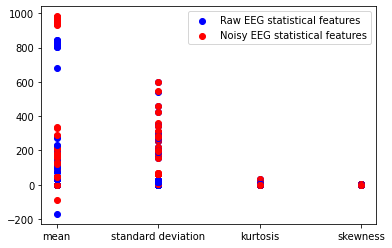

In [10]:
for i in range(len(raw_stats)):
    p1=plt.scatter(['mean', 'standard deviation', 'kurtosis', 'skewness'],raw_stats[i],color='blue')
    p2=plt.scatter(['mean', 'standard deviation', 'kurtosis', 'skewness'],n_stats[i],color='red')
p1.set_label('Raw EEG statistical features')
p2.set_label('Noisy EEG statistical features')
plt.legend()
plt.show()

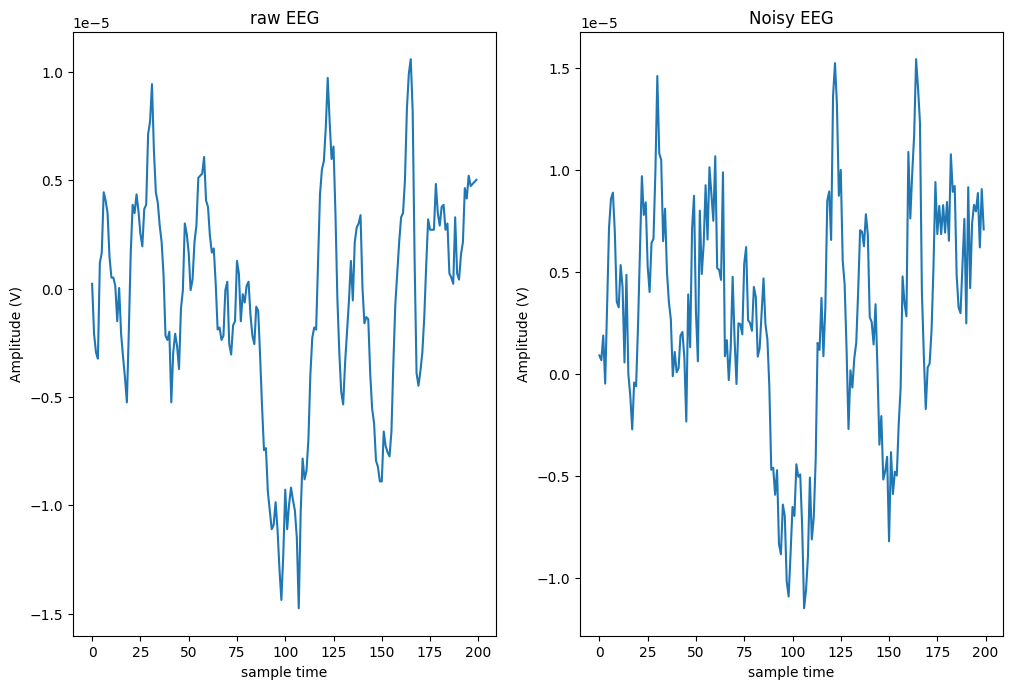

In [11]:
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
plt.plot(data[1][sample_times[12][0]:sample_times[12][1]][500:700])
plt.title("raw EEG")
plt.xlabel('sample time')
plt.ylabel('Amplitude (V)')

plt.subplot(1, 2, 2) 
plt.plot(SNR_Set(data[1][sample_times[12][0]:sample_times[12][1]],7)[500:700])
plt.title("Noisy EEG")
plt.xlabel('sample time')
plt.ylabel('Amplitude (V)')

plt.show()